In [74]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv1D, MaxPooling1D, Softmax, Reshape
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.backend import clear_session


from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import copy

# Process dataset
Extract data from the txt file for each user. We only extract the data for the time frame where the user is doing one action, not across different actions. Then we segment the data into 2 seconds window.

In [2]:
# file loader
from os.path import isfile

def load_data(file):
    data = pd.read_csv(file, header=None)
    return data.values

In [64]:
window_size = 75   # 50Hz, 75 samples = 1.5s of movement
window_stride = 25
action_types = ('shield', 'reload', 'grenade', 'final')
data_depth = 6

dataset_users = [0, 1, 2, 3]

# Function to load dataset
def load_dataset(data_dir):
    dataset_x = []
    dataset_y = []
    
    for i in dataset_users:
        user_data_dir = f"{data_dir}/user{i}"
        print(f"Loading data from {user_data_dir}")
    
        for action_type in action_types:

            for i in range(1, 100, 1):
                # if file exists
                if not isfile(user_data_dir + f"/{action_type}{i}.csv"):
                    # print number of files loaded
                    print(f"Loaded {i-1} {action_type} files")
                    break
                data = load_data(user_data_dir + f"/{action_type}{i}.csv")
                dataset_x.append(np.int32(data))
                dataset_y.append(action_types.index(action_type))

    print("Dataset initialized with size: " + str(len(dataset_y)))
    for i in range(len(action_types)):
        print("Class " + str(i) + " has " + str(dataset_y.count(i)) + " samples")
    dataset_y = to_categorical(dataset_y)
    return dataset_x, np.array(dataset_y)

def load_idle_dataset(data_dir):
    dataset_x = []
    dataset_y = []
    
    for i in dataset_users:
        user_data_dir = f"{data_dir}/user{i}"
        print(f"Loading idle data from {user_data_dir}")
    
        for i in range(1, 100, 1):
            # if file exists
            if not isfile(user_data_dir + f"/idle{i}.csv"):
                break
            data = load_data(user_data_dir + f"/idle{i}.csv")
            dataset_x.append(data)
            dataset_y.append([0.25, 0.25, 0.25, 0.25])

    print("Idle dataset initialized with size: " + str(len(dataset_y)))
    return dataset_x, np.array(dataset_y)

# To do sliding window on the data
def sliding_window(data_X, data_Y, window_size, window_stride):
    dataset_X_w_sliding = []
    dataset_Y_w_sliding = []
    for i in range(len(data_X)):
        for j in range(0, len(data_X[i]) - window_size+1, window_stride):
            dataset_X_w_sliding.append(data_X[i][j:j + window_size])
            dataset_Y_w_sliding.append(data_Y[i])
    return np.array(dataset_X_w_sliding), np.array(dataset_Y_w_sliding)


# load dataset
dataset_x, dataset_y = load_dataset("Dataset")

# split into train and test sets
train_x, test_x, train_y, test_y = train_test_split(dataset_x, dataset_y, test_size=0.2, stratify = dataset_y, random_state=666)

# backup test set for evaluation
test_x_eval = copy.deepcopy(test_x)
test_y_eval = copy.deepcopy(test_y)

# combine the training data with idle data
dataset_x_idle, dataset_y_idle = load_idle_dataset("Dataset")
train_x.extend(dataset_x_idle)
train_y = np.concatenate((train_y, dataset_y_idle), axis=0)

# sliding window after train_test_split
train_x, train_y = sliding_window(train_x, train_y, window_size, window_stride)
test_x, test_y = sliding_window(test_x, test_y, window_size, window_stride)

# print dataset size after sliding window
print("Dataset size after sliding window: " + str(len(train_y)))

# calculate class weights
class_weights = {}
for i in range(len(action_types)):
    class_weights[i] = 1 / dataset_y[:, i].sum()

# print dataset disribution
train_y_temp = np.argmax(train_y, axis=1)
for i in range(len(action_types)):
    print("Class " + str(i) + " has " + str(train_y_temp.tolist().count(i)) + " samples")

# backup test_x for c_sim and cosim
test_x_copy = copy.deepcopy(test_x)

# convert data from int16 to float32
train_x, test_x = np.float32(train_x)/4096, np.float32(test_x)/4096
# print("sample test x data: " + str(test_x[0]))

# summary of test dataset
test = np.argmax(test_y, axis=1)
print("\nTest set distribution")
for i in range(len(action_types)):
    print("Class " + str(i) + " has " + str(test.tolist().count(i)) + " samples")


Loading data from Dataset/user0
Loaded 15 shield files
Loaded 15 reload files
Loaded 15 grenade files
Loaded 20 final files
Loading data from Dataset/user1
Loaded 20 shield files
Loaded 15 reload files
Loaded 20 grenade files
Loaded 20 final files
Loading data from Dataset/user2
Loaded 20 shield files
Loaded 13 reload files
Loaded 14 grenade files
Loaded 20 final files
Loading data from Dataset/user3
Loaded 20 shield files
Loaded 14 reload files
Loaded 20 grenade files
Loaded 20 final files
Dataset initialized with size: 281
Class 0 has 75 samples
Class 1 has 57 samples
Class 2 has 69 samples
Class 3 has 80 samples
Loading idle data from Dataset/user0
Loading idle data from Dataset/user1
Loading idle data from Dataset/user2
Loading idle data from Dataset/user3
Idle dataset initialized with size: 20
Dataset size after sliding window: 1703
Class 0 has 853 samples
Class 1 has 230 samples
Class 2 has 286 samples
Class 3 has 334 samples

Test set distribution
Class 0 has 75 samples
Class 1 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 73, 32)            608       
                                                                 
 dropout (Dropout)           (None, 73, 32)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 24, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 22, 16)            1552      
                                                                 
 dropout_1 (Dropout)         (None, 22, 16)            0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 7, 16)            0         
 1D)                                                    

2022-10-04 12:11:19.971648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


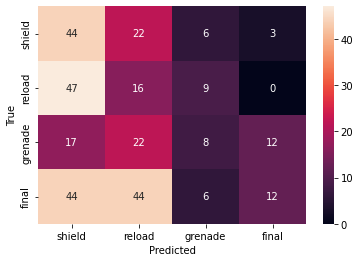

In [95]:
conv1filters = 32
conv1kernel = 3
conv1stride = 1

clear_session()
model = Sequential()
model.add(Conv1D(conv1filters, conv1kernel, strides=conv1stride, activation='relu', input_shape=(window_size, 6)))
model.add(Dropout(0.5)) # 50% dropout
model.add(MaxPooling1D(3))
model.add(Conv1D(16, 3, activation='relu'))
model.add(Dropout(0.5)) # 50% dropout
model.add(MaxPooling1D(3))
model.add(Flatten())
# model.add(Dense(16, activation='relu'))
model.add(Dense(len(action_types)))
model.add(Softmax())

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# performance before training
y_prediction = np.argmax(model.predict(test_x), axis=1)
result = confusion_matrix(np.argmax(test_y, axis=1), y_prediction)
sns.heatmap(result, annot=True, fmt="d", xticklabels=action_types, yticklabels=action_types)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [96]:
# checkpoint callback
checkpoint_filepath = "model_checkpoint/"
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

# learning rate reduce on plateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=50, min_lr=0)

# early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True)

In [97]:
import time

# Train the model
def train_network(model, train_x, train_y, test_x, test_y):
    verbose = 1 # 0 for no logging to stdout, 1 for progress bar logging, 2 for one log line per epoch.
    epochs = 1000
    batch_size = 128
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, validation_data=(test_x, test_y), class_weight = class_weights, callbacks = [model_checkpoint_callback, reduce_lr, early_stopping], verbose=verbose)
    _, accuracy = model.evaluate(test_x, test_y, batch_size=batch_size, verbose=0)
    return model

start_time = time.time()
model = train_network(model, train_x, train_y, test_x, test_y)
print("Training time: %s seconds" % (time.time() - start_time))

Epoch 1/1000


2022-10-04 12:11:29.506937: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 1s 26ms/step - loss: 0.0232 - accuracy: 0.3194 - val_loss: 1.3234 - val_accuracy: 0.3590 - lr: 0.0010
Epoch 2/1000
 6/14 [===========>..................] - ETA: 0s - loss: 0.0202 - accuracy: 0.3216

2022-10-04 12:11:30.078703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


14/14 [==============================] - 0s 15ms/step - loss: 0.0195 - accuracy: 0.3171 - val_loss: 1.2935 - val_accuracy: 0.4327 - lr: 0.0010
Epoch 3/1000
14/14 [==============================] - 0s 14ms/step - loss: 0.0179 - accuracy: 0.3564 - val_loss: 1.2630 - val_accuracy: 0.5064 - lr: 0.0010
Epoch 4/1000
14/14 [==============================] - 0s 14ms/step - loss: 0.0173 - accuracy: 0.3705 - val_loss: 1.2147 - val_accuracy: 0.5801 - lr: 0.0010
Epoch 5/1000
14/14 [==============================] - 0s 15ms/step - loss: 0.0164 - accuracy: 0.4046 - val_loss: 1.1538 - val_accuracy: 0.6635 - lr: 0.0010
Epoch 6/1000
14/14 [==============================] - 0s 14ms/step - loss: 0.0155 - accuracy: 0.4281 - val_loss: 1.0867 - val_accuracy: 0.6923 - lr: 0.0010
Epoch 7/1000
14/14 [==============================] - 0s 17ms/step - loss: 0.0147 - accuracy: 0.4756 - val_loss: 1.0175 - val_accuracy: 0.7179 - lr: 0.0010
Epoch 8/1000
14/14 [==============================] - 0s 15ms/step - loss: 0.

# Draw confusion matrix

Proportion of filtered prediction: 0.7019230769230769
Highest false confidence: 0.86824876


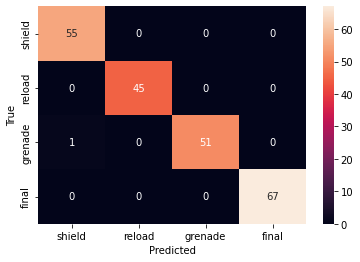

Accuracy: 0.9954337899543378


In [102]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

highest_false_confidence = 0

# model.load_weights(checkpoint_filepath)
y_prediction = model.predict(test_x)

threshold = 0.7
# remove all the prediction with probability less than threshold
filtered_pred = []
filtered_test = []
for i in range(len(y_prediction)):
    if np.max(y_prediction[i]) > threshold:
        filtered_pred.append(np.argmax(y_prediction[i]))
        filtered_test.append(np.argmax(test_y[i]))
        if np.max(y_prediction[i]) > highest_false_confidence and np.argmax(y_prediction[i]) != np.argmax(test_y[i]):
            highest_false_confidence = np.max(y_prediction[i])

# print proportion of filtered prediction
print("Proportion of filtered prediction: " + str(len(filtered_pred)/len(y_prediction)))

# print highest false confidence
print("Highest false confidence: " + str(highest_false_confidence))

result = confusion_matrix(filtered_test, filtered_pred)

# result = confusion_matrix(np.argmax(test_y, axis=1), y_prediction)
sns.heatmap(result, annot=True, fmt="d", xticklabels=action_types, yticklabels=action_types)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# print accuracy
print("Accuracy: " + str(np.sum(np.diag(result))/np.sum(result)))


prediction ended at window 201
best prob: 0.7348029
prediction ended at window 32
best prob: 0.7071132
prediction ended at window 41
best prob: 0.70677644
prediction ended at window 83
best prob: 0.8626052
prediction ended at window 81
best prob: 0.72845685
prediction ended at window 39
best prob: 0.7313031
prediction ended at window 91
best prob: 0.71763873
prediction ended at window 70
best prob: 0.7051119
prediction ended at window 34
best prob: 0.727696
prediction ended at window 62
best prob: 0.7463812
prediction ended at window 47
best prob: 0.7318915
prediction ended at window 48
best prob: 0.7675914
prediction ended at window 26
best prob: 0.7074313
prediction ended at window 115
best prob: 0.71370137
prediction ended at window 25
best prob: 0.72678894
prediction ended at window 31
best prob: 0.71782637
prediction ended at window 23
best prob: 0.71840376
prediction ended at window 41
best prob: 0.71018445
prediction ended at window 35
best prob: 0.74578494
prediction ended at w

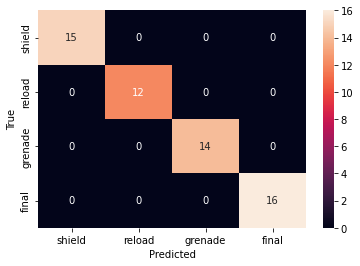

Accuracy: 1.0
Highest false confidence: 0.6454771


In [103]:
# evaluate actual performance
pred = []
actual = []
highest_false_confidence = 0
for i in range(len(test_x_eval)):
    data = np.array(test_x_eval[i])
    # sliding window until the prediction has probability greater than threshold, or end of the sequence and give the prediction with highest probability
    best_pred, best_prob = 0, 0
    for w in range(conv1kernel, len(data), conv1stride):
        x = np.array(data[max(0, w-window_size):w])
        x = np.concatenate((np.zeros((window_size - x.shape[0], 6)), x))
        x = np.float32(x)/4096
        y = model.predict(np.array([x]))
        # print(f"current window: {w}, prediction: {np.argmax(y)}, probability: {np.max(y)}, actual: {np.argmax(test_y_eval[i])}")
        if np.max(y) > highest_false_confidence and np.argmax(y) != np.argmax(test_y_eval[i]):
            highest_false_confidence = np.max(y)
        if np.max(y) > best_prob:
            best_pred = np.argmax(y)
            best_prob = np.max(y)
        if np.max(y) > threshold:
            print("prediction ended at window " + str(w))
            break
    print("best prob: ", str(best_prob), "w correct predict" if best_pred == np.argmax(test_y_eval[i]) else "w wrong predict")
    pred.append(best_pred)
    actual.append(np.argmax(test_y_eval[i]))
result = confusion_matrix(actual, pred)
sns.heatmap(result, annot=True, fmt="d", xticklabels=action_types, yticklabels=action_types)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# print accuracy
print("Accuracy: " + str(np.sum(np.diag(result))/np.sum(result)))

# print highest false confidence
print("Highest false confidence: " + str(highest_false_confidence))

In [ ]:
print(f"window shape: {window_size, data_depth}")
print(f"kernel shape: {conv1kernel, data_depth}")
print(f"first layer weights shape: {model.layers[0].get_weights()[0].shape}")
print(f"first layer output shape: {model.layers[0].output_shape}")
print(f"second layer weights shape: {model.layers[3].get_weights()[0].shape}")
print(f"second layer output shape: {model.layers[3].output_shape}")

In [ ]:
# print out weights and biases one by one
layers_indexes = [0, 3]

for layer_index in layers_indexes:
    layer = model.layers[layer_index]
    layer_name = layer.name
    weights = layer.get_weights()
    print(weights[0].shape)
    print(f"INPUT_DTYPE model_param_{layer_name}_weights")
    for i in range(weights[0].shape[-1]):
        print("index", i)
        print(np.transpose(np.transpose(weights[0])[i]))
    print(f"INPUT_DTYPE model_param_{layer_name}_biases")
    print(weights[1].shape)

In [ ]:
# directly print out weights and biases
layers_indexes = [0, 3]

for layer_index in layers_indexes:
    layer = model.layers[layer_index]
    layer_name = layer.name
    weights = layer.get_weights()
    if layer_index == 0:
        layer_name = "CNN"
        weights_size_definition = "[CNN_KERNEL_LENGTH][CNN_KERNEL_DEPTH][CNN_KERNEL_COUNT]"
        bias_size_definition = "[CNN_KERNEL_COUNT]"
    else:
        layer_name = "dense"
        weights_size_definition = "[DENSE_INPUT_NODES][DENSE_OUTPUT_NODES]"
        bias_size_definition = "[DENSE_OUTPUT_NODES]"
    print(f"static INPUT_DTYPE {layer_name}_weights{weights_size_definition} = {{" + ", ".join([str(x) for x in weights[0].reshape(-1)]) + "};")
    print(f"static INPUT_DTYPE {layer_name}_bias{bias_size_definition} = {{" + ", ".join([str(x) for x in weights[1]]) + "};")

    # save weights and biases to file
    np.save(f"{layer_name}_weights.npy", weights[0])
    np.save(f"{layer_name}_bias.npy", weights[1])


In [ ]:
# directly print out test dataset
n_values_per_line = 10
dataset_size = len(test_x)
# dataset_size = 1
dataset_start_index = 0
print("#define DATASET_SIZE", dataset_size)

# print out float test dataset
print(f"const float test_x[DATASET_SIZE][INPUT_LENGTH][INPUT_DEPTH] = {{")
for text_x_index in range(dataset_start_index, min(test_x.shape[0], dataset_start_index + dataset_size)):
    for datapoint_index in range(0, len(test_x[text_x_index])):
        for i in range(0, len(test_x[text_x_index][datapoint_index]), n_values_per_line):
            print(", ".join([str(x) for x in test_x_copy[text_x_index][datapoint_index][i:i+n_values_per_line]]) + ",")
print("};") 
    
print(f"const int test_y[DATASET_SIZE][DENSE_OUTPUT_NODES] = {{")
for text_x_index in range(dataset_start_index, min(test_x.shape[0], dataset_start_index + dataset_size)):
    for i in range(0, len(test_y[text_x_index]), n_values_per_line):
        print(", ".join([str(int(x)) for x in test_y[text_x_index][i:i+n_values_per_line]]) + ",")
print("};")

# save the test dataset
np.save("test_x.npy", test_x_copy)
np.save("test_y.npy", test_y)

In [ ]:
# print model output without the last layer
from keras.models import Model
model_without_last_layer = Model(inputs=model.input, outputs=model.layers[-2].output)
model_without_last_layer.summary()
predicted_result = model_without_last_layer.predict(test_x)[0]
print(predicted_result.shape)
print(predicted_result)
